<a href="https://colab.research.google.com/github/IBM-CSM-SG/DTSA5510/blob/main/DTSA_5510_Unsupervised_Algorithms_in_Machine_Learning_Final_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.layers import BatchNormalization,Concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Brief description of the problem and data**

**Description**

In this project, we aim to develop a machine learning model to remove noise from scanned text documents and restore them to their clean, readable versions. Optical Character Recognition (OCR) is widely used to digitize printed and handwritten documents, but real-world issues like stains, wrinkles, and smudges make OCR less effective. The goal of this project is to create a document enhancement model that improves text clarity by removing noise while preserving the original content.

The methodology will include the following stages:

* Brief Description of the Problem and Data
* Data Preprocessing and Exploratory Data Analysis (EDA)
* Model Architecture and Development
* Model Evaluation
* Results and Analysis
* Conclusion

**Data**

The dataset consists of scanned text images with synthetic noise added to simulate real-world document degradation. It contains:

* train/: Noisy images used for training.
* train_cleaned/: Corresponding clean (ground truth) versions of the images.
* test/: Noisy test images where the model must remove noise.
* sampleSubmission.csv: A sample submission file that shows the required format for Kaggle.

Each image is grayscale, with pixel intensity values ranging from 0 (black) to 1 (white). The submission format requires flattening the image into a list of pixel values, each assigned a unique ID (image_row_col).

In [3]:
# Define dataset paths
dataset_path = "/content/drive/My Drive/DTSA5510/final/"
train_path = os.path.join(dataset_path, "train")
train_cleaned_path = os.path.join(dataset_path, "train_cleaned")
test_path = os.path.join(dataset_path, "test")

In [4]:
# Count images each folders
def count_images(directory):
    return len(os.listdir(directory))

print("Number of Train Images:", count_images(train_path))
print("Number of Train Cleaned Images:", count_images(train_cleaned_path))
print("Number of Test Images:", count_images(test_path))

Number of Train Images: 144
Number of Train Cleaned Images: 144
Number of Test Images: 72


In [5]:
# Inspect
print("Train set sample files:", os.listdir(train_path)[:5])
print("Train Cleaned set sample files:", os.listdir(train_cleaned_path)[:5])
print("Test set sample files:", os.listdir(test_path)[:5])

Train set sample files: ['33.png', '8.png', '42.png', '45.png', '15.png']
Train Cleaned set sample files: ['56.png', '36.png', '60.png', '47.png', '8.png']
Test set sample files: ['16.png', '40.png', '79.png', '91.png', '13.png']


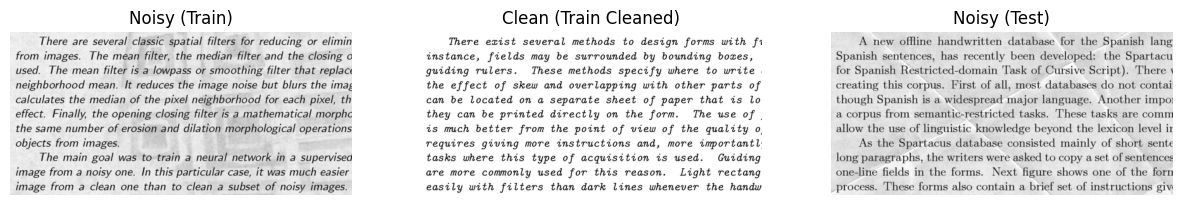

In [6]:
# Inspect and display images
sample_noisy = os.path.join(train_path, os.listdir(train_path)[0])
sample_clean = os.path.join(train_cleaned_path, os.listdir(train_cleaned_path)[0])
sample_test = os.path.join(test_path, os.listdir(test_path)[0])

def display_images(img_paths, titles, figsize=(15, 5)):
    fig, axes = plt.subplots(1, len(img_paths), figsize=figsize)
    for ax, img_path, title in zip(axes, img_paths, titles):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis("off")
    plt.show()

display_images(
    [sample_noisy, sample_clean, sample_test],
    ["Noisy (Train)", "Clean (Train Cleaned)", "Noisy (Test)"]
)

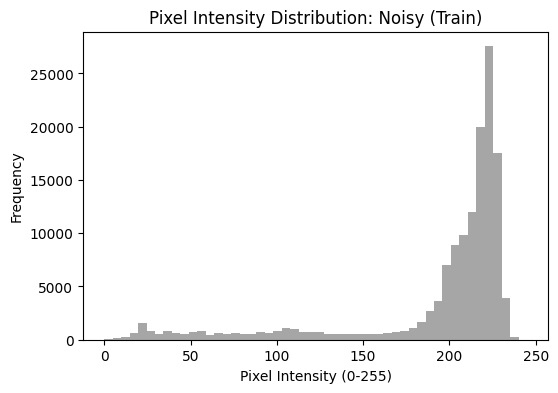

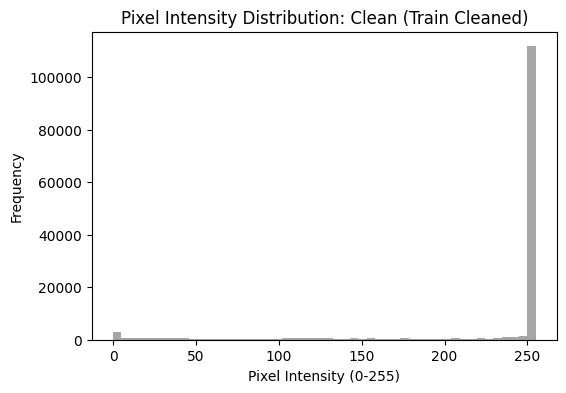

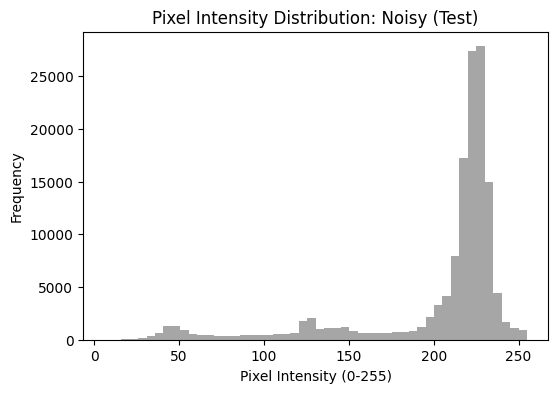

In [7]:
# Analyze Pixel Intensity Distribution
def plot_histogram(img_path, title):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(6, 4))
    plt.hist(img.ravel(), bins=50, color='gray', alpha=0.7)
    plt.title(f"Pixel Intensity Distribution: {title}")
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Frequency")
    plt.show()

# Plot histograms for noisy, cleaned, and test images
plot_histogram(sample_noisy, "Noisy (Train)")
plot_histogram(sample_clean, "Clean (Train Cleaned)")
plot_histogram(sample_test, "Noisy (Test)")

In [8]:
# Image Size Consistency
def check_image_shapes(directory):
    shapes = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        shapes.append(img.shape)
    return set(shapes)

# Check consistency in all datasets
print("Train Image Shapes:", check_image_shapes(train_path))
print("Train Cleaned Image Shapes:", check_image_shapes(train_cleaned_path))
print("Test Image Shapes:", check_image_shapes(test_path))

Train Image Shapes: {(420, 540), (258, 540)}
Train Cleaned Image Shapes: {(420, 540), (258, 540)}
Test Image Shapes: {(420, 540), (258, 540)}


**EDA Summary**

* **Dataset Completeness:** The dataset contains 144 training images with corresponding clean versions and 72 test images, ensuring full data availability for training and evaluation.

* **Image Size Variability:** The dataset has two unique image sizes, (420, 540) and (258, 540), requiring resizing for model consistency.

* **Noise Characteristics**: Noisy images contain dark artifacts, stains, and wrinkles, causing pixel intensity distributions to be more spread out compared to the clean images, which are mostly concentrated near 255 (white background).

* **Train vs. Test Similarity:** The test images exhibit similar noise patterns as the training set, confirming that denoising methods trained on the dataset should generalize well to test images.

* **Preprocessing Needs**: Due to varied noise types and intensity distributions, preprocessing should include grayscale conversion, normalization, and potential adaptive thresholding before applying denoising techniques.

**3. Model Architecture and Development**

Data Processing: Normalize pixel values and resize.

In [9]:
# Set image dimensions
IMG_HEIGHT, IMG_WIDTH = 256, 256

In [10]:
# Data Processing Functions
def load_images(directory, resize_shape=(IMG_HEIGHT, IMG_WIDTH)):
    images = []
    for img_name in sorted(os.listdir(directory)):
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, resize_shape)
        img = img.astype("float32") / 255.0
        images.append(img)
    return np.array(images).reshape(-1, resize_shape[0], resize_shape[1], 1)

In [11]:
# Load noisy and clean images
train_noisy = load_images(train_path)
train_clean = load_images(train_cleaned_path)

# Print dataset shape
print(f"Train Noisy Shape: {train_noisy.shape}")
print(f"Train Clean Shape: {train_clean.shape}")

Train Noisy Shape: (144, 256, 256, 1)
Train Clean Shape: (144, 256, 256, 1)


Define Convolutional Autoencoder Model

In [12]:
# Define the autoencoder architecture
def build_autoencoder(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    output_img = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output layer

    # Compile model
    autoencoder = Model(input_img, output_img)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

In [13]:
# Instantiate the model
autoencoder = build_autoencoder()

In [14]:
# Print model summary
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [15]:
# Train the model
history = autoencoder.fit(
    train_noisy, train_clean,
    epochs=30, batch_size=16,
    shuffle=True, validation_split=0.1
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 480ms/step - loss: 0.1332 - val_loss: 0.0610
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0698 - val_loss: 0.0619
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0707 - val_loss: 0.0620
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0700 - val_loss: 0.0620
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0698 - val_loss: 0.0620
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0696 - val_loss: 0.0620
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0689 - val_loss: 0.0620
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0711 - val_loss: 0.0612
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0645 - val_loss: 0.0530
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0559 - val_loss: 0.0513
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0506 - val_loss: 0.0420
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0446 - val_loss: 0.0408

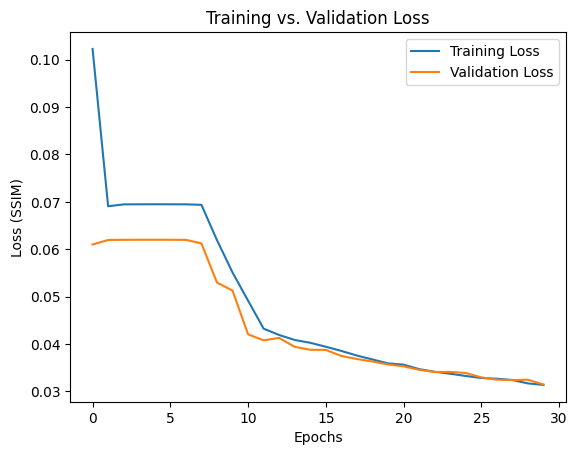

In [16]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (SSIM)")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.show()

Evaluate Model Performance

In [17]:
# Predict
test_noisy = load_images(test_path)
denoised_images = autoencoder.predict(test_noisy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 537ms/step


In [18]:
# Display results
def display_denoising_results(noisy, denoised, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))

    for i in range(num_samples):
        axes[i, 0].imshow(noisy[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        axes[i, 0].set_title("Noisy Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(denoised[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        axes[i, 1].set_title("Denoised Image")
        axes[i, 1].axis("off")

    plt.show()

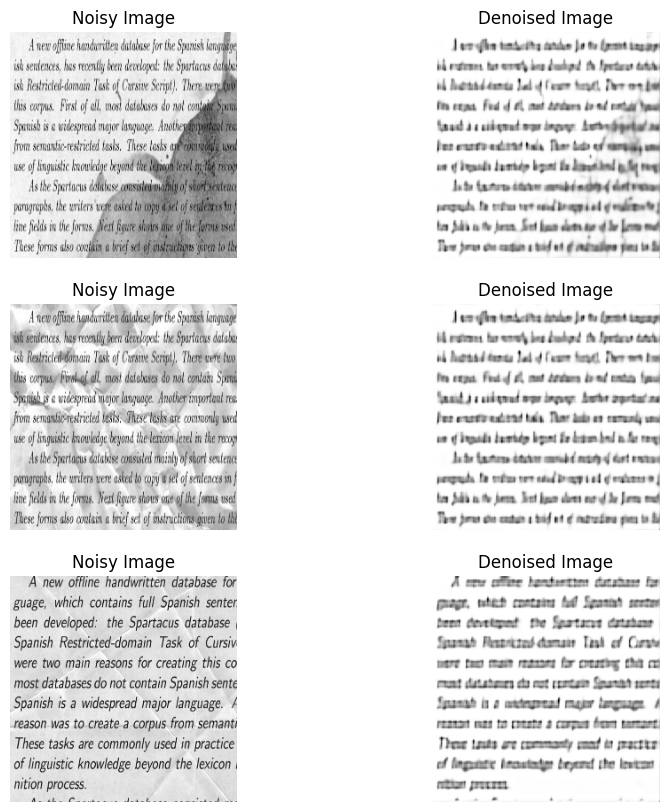

In [19]:
# Show test results
display_denoising_results(test_noisy, denoised_images)

In [20]:
# Because we don't have test ground truth - So, I calculate RMSE based on Train data set to measure the performance.
denoised_train = autoencoder.predict(train_noisy)
rmse_scores = [
    np.sqrt(mean_squared_error(train_clean[i].flatten(), denoised_train[i].flatten()))
    for i in range(len(train_clean))
]
overall_rmse = np.mean(rmse_scores)
overall_rmse

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


0.17587994062126652

**The first model, the perfomance is good. The RMSE is 0.175 which is okay. However, we still can improve the denoised images which appear blurred and less clear, which suggests that the model is:**

* Removing too much detail, affecting text sharpness.
* Smoothing out noise, but at the cost of reducing readability.
* Not preserving fine edges, leading to loss of text structure.

**SSIM Loss Function:** SSIM (Structural Similarity Index) measures how similar two images are, focusing on text clarity rather than pixel-wise differences.

In [21]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [22]:
# Define the autoencoder architecture (same as before)
def build_autoencoder(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    output_img = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output layer

    # Compile model with SSIM loss
    autoencoder = Model(input_img, output_img)
    autoencoder.compile(optimizer='adam', loss=ssim_loss)

    return autoencoder

In [23]:
# Build the autoencoder
enhance_autoencoder = build_autoencoder()
enhance_autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 256, 256, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train the model with SSIM loss
history = enhance_autoencoder.fit(
    train_noisy, train_clean,
    epochs=100,
    batch_size=16,
    shuffle=True,
    validation_split=0.1
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 312ms/step - loss: 0.7930 - val_loss: 0.7150
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.7260 - val_loss: 0.6403
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.6181 - val_loss: 0.5683
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.5496 - val_loss: 0.5343
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.5235 - val_loss: 0.5122
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4976 - val_loss: 0.4896
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.4700 - val_loss: 0.4802
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4667 - val_loss: 0.4609
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4412 - val_loss: 0.4455
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4309 - val_loss: 0.4430
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.4276 - val_loss: 0.4246
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.4094 - val_l

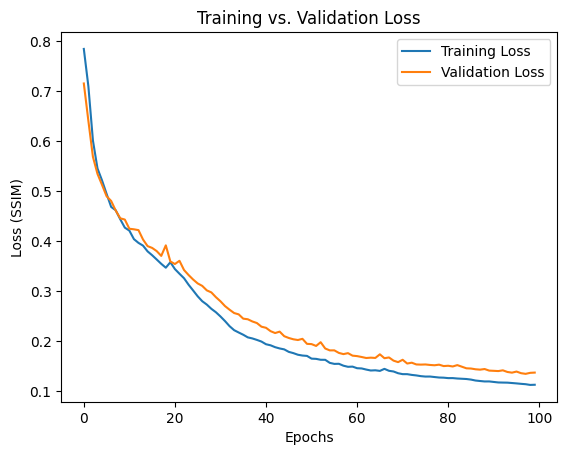

In [25]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (SSIM)")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.show()

In [26]:
# Predict
test_noisy = load_images(test_path)
enhance_denoised_images = enhance_autoencoder.predict(test_noisy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


In [27]:
# Display results
def display_denoising_results(noisy, denoised, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))

    for i in range(num_samples):
        axes[i, 0].imshow(noisy[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        axes[i, 0].set_title("Noisy Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(denoised[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        axes[i, 1].set_title("Denoised Image")
        axes[i, 1].axis("off")

    plt.show()

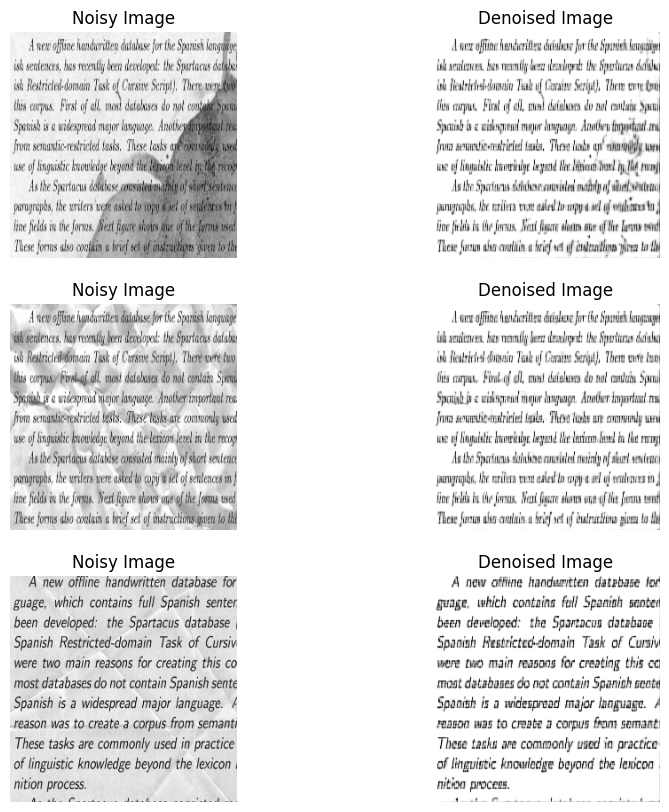

In [28]:
# Show test results
display_denoising_results(test_noisy, enhance_denoised_images)

In [29]:
# Because we don't have test ground truth - So, I calculate RMSE based on Train data set to measure the performance.
denoised_train = enhance_autoencoder.predict(train_noisy)
rmse_scores = [
    np.sqrt(mean_squared_error(train_clean[i].flatten(), denoised_train[i].flatten()))
    for i in range(len(train_clean))
]

overall_rmse = np.mean(rmse_scores)

print(f"Overall RMSE Score: {overall_rmse:.5f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Overall RMSE Score: 0.11239


**Results and Analysis**

Please see the comparison between original, denoised with autoencoder and denoised with enhanced autoencoder model below.

* Convolutional Autoencoder performs well with SSIM loss and longer training, Enhanced Autoencoder. The denoised images show clear improvements in quality.It produces sharper, more readable text compared to the basic autoencoder, effectively reducing noise and improving contrast.
* The RMSE confirm that the enhacement model is better, RMSE 0.1123 comparing to RMSE, 0.175 from previous model.
* The basic autoencoder struggles with fine text details, producing blurred outputs, while the enhanced model preserves more text structures and improves readability.
* Future improvements could explore GAN-based denoising or Transformer-based architectures to further enhance the model’s ability to restore text clarity.



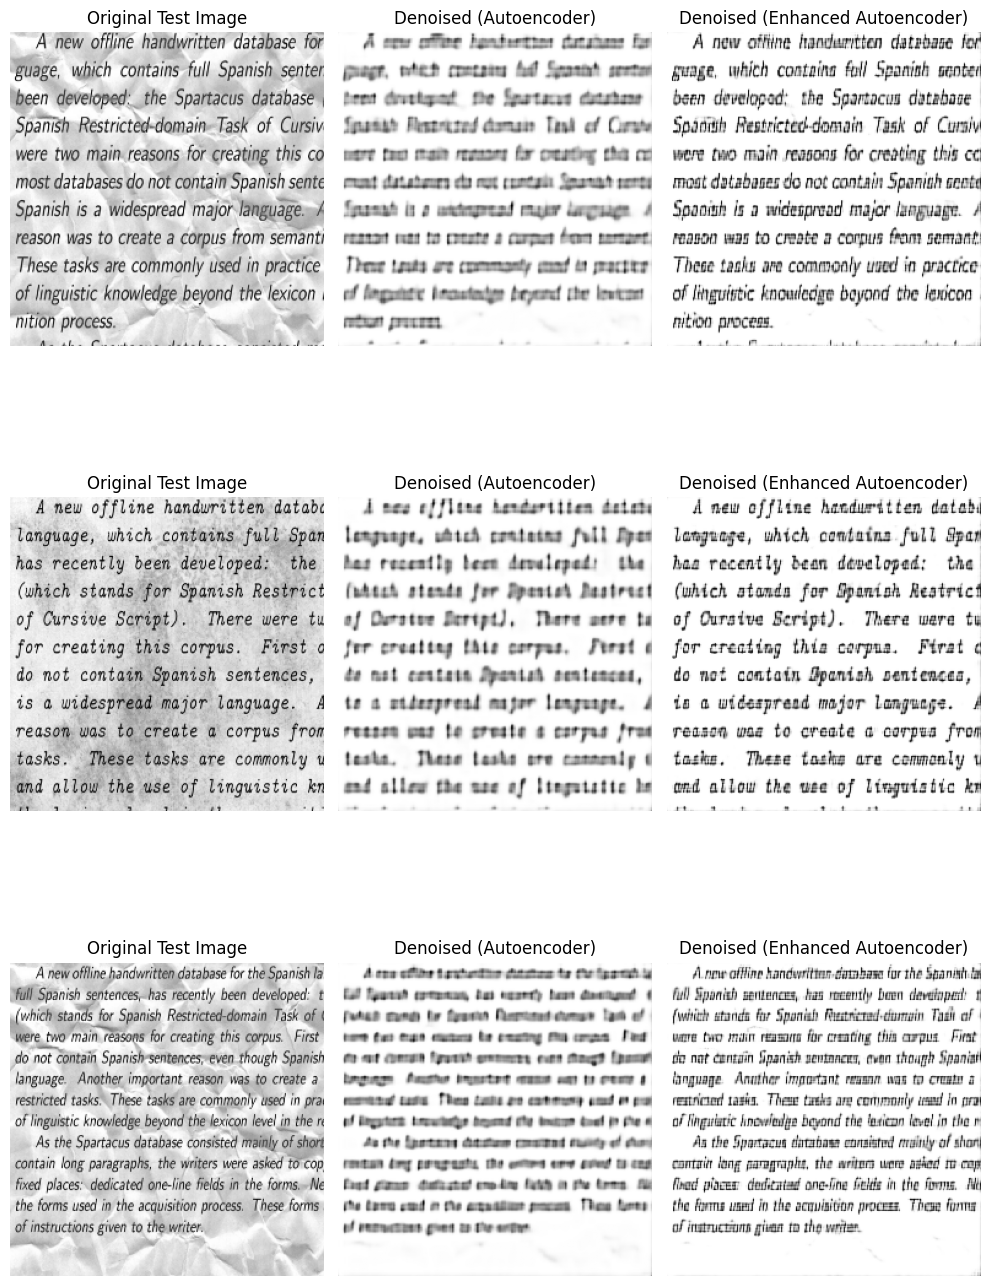

In [30]:
# Select random indices to visualize
num_images = 3
random_indices = np.random.choice(len(test_noisy), num_images, replace=False)

# Plot comparison
fig, axes = plt.subplots(num_images, 3, figsize=(10, 15))

for i, idx in enumerate(random_indices):
    # Original test image
    test_img = test_noisy[idx]
    denoised_img = denoised_images[idx]
    enhanced_img = enhance_denoised_images[idx]

    # Plot original
    axes[i, 0].imshow(test_img, cmap='gray')
    axes[i, 0].set_title("Original Test Image")
    axes[i, 0].axis("off")

    # Plot autoencoder denoised image
    axes[i, 1].imshow(denoised_img, cmap='gray')
    axes[i, 1].set_title("Denoised (Autoencoder)")
    axes[i, 1].axis("off")

    # Plot enhanced autoencoder denoised image
    axes[i, 2].imshow(enhanced_img, cmap='gray')
    axes[i, 2].set_title("Denoised (Enhanced Autoencoder)")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

**Conclusion:**

* As you can see, the application of an unsupervised learning model, specifically the autoencoder, can effectively learn latent representations of noisy images and restore clean versions without requiring labeled data. This makes it a powerful tool for various real-world applications.
* The fine-tuned autoencoder with SSIM loss demonstrates significant improvement over the basic model, producing sharper, more readable text while preserving structural details. The results show that deep learning-based denoising can be highly effective in restoring degraded, historical, or handwritten documents.
* Beyond document restoration and OCR preprocessing, autoencoders can be applied to medical imaging, satellite image enhancement, and security applications.
* The enhanced model’s performance suggests that further improvements can be explored through GAN-based denoising, transformer architectures, or multi-scale feature extraction techniques to achieve even higher-quality restorations.